In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Epoch 1/1000, Loss: 7580.573649
Epoch 51/1000, Loss: 37.162250
Epoch 101/1000, Loss: 40.170204
Epoch 151/1000, Loss: 39.610209
Epoch 201/1000, Loss: 38.772895
Epoch 251/1000, Loss: 43.730193
Epoch 301/1000, Loss: 39.789336
Epoch 351/1000, Loss: 37.825463
Early stopping at epoch 387

Training Complete!


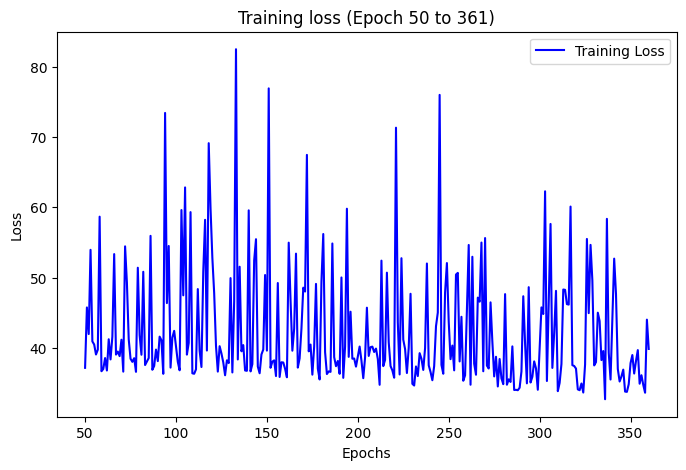

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
import pickle
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

# Set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load train and test CSV files
train_df = pd.read_csv("/content/drive/MyDrive/BioSensorer/train_data.csv")
test_df = pd.read_csv("/content/drive/MyDrive/BioSensorer/test_data.csv")

# Separate features (X) and target (y)
y_train = train_df.iloc[:, 0].values
X_train = train_df.iloc[:, 1:].values

y_test = test_df.iloc[:, 0].values
X_test = test_df.iloc[:, 1:].values

# Exclude specific columns
exclude_cols = [5]
X_train = train_df.drop(train_df.columns[exclude_cols], axis=1).iloc[:, 1:].values
X_test = test_df.drop(test_df.columns[exclude_cols], axis=1).iloc[:, 1:].values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create PyTorch DataLoaders
batch_size = 8
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the ANN Model
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 4),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(4, 2),
            nn.ReLU(),
            nn.Dropout(0.0),
            nn.Linear(2, 1)
        )

    def forward(self, x):
        return self.model(x)

# Initialize the model
input_size = X_train.shape[1]
model = RegressionModel(input_size)

# Define Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)

# Train the Model and Track Loss
num_epochs = 1000
best_loss = float('inf')
patience = 50
counter = 0
train_losses = []  # Track loss per epoch

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    if avg_loss < best_loss:
        best_loss = avg_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    if epoch % 50 == 0 or epoch == num_epochs - 1:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}")

print("\nTraining Complete!")

# Define the range of epochs to plot
plot_start_epoch = 50
plot_end_epoch = 361

# Ensure the selected range is within available epochs
plot_start_epoch = max(0, plot_start_epoch)
plot_end_epoch = min(len(train_losses), plot_end_epoch)

# Create an index range for plotting
epochs_range = list(range(plot_start_epoch, plot_end_epoch))

# Plot the training and validation loss curve for the specified range
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses[plot_start_epoch:plot_end_epoch], label="Training Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title(f"Training loss (Epoch {plot_start_epoch} to {plot_end_epoch})")
plt.legend()
plt.show()



In [ ]:
# Ensure model is in evaluation mode
model.eval()

# Make predictions on the test set
with torch.no_grad():
    y_pred = model(X_test_tensor)

# Compute RMSE
mse = mean_squared_error(y_test_tensor.numpy(), y_pred.numpy())
rmse = np.sqrt(mse)

print(f"Test RMSE: {rmse:.4f}")

# Save the model
model_path = "model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(model, f)

print(f"Model saved to {model_path}")


Test RMSE: 7.2969
Model saved to model.pkl


In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# Make predictions on the test set
with torch.no_grad():
    y_pred = model(X_test_tensor)

# Convert predictions and targets back to numpy for easier printing
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Print the predicted and target values for each sample in the test set
for i in range(len(y_test_np)):
    print(f"Sample {i+1}: Predicted = {y_pred_np[i][0]:.4f}, Target = {y_test_np[i][0]:.4f}")


Sample 1: Predicted = 89.4152, Target = 103.0000
Sample 2: Predicted = 71.6492, Target = 62.0000
Sample 3: Predicted = 94.4466, Target = 88.0000
Sample 4: Predicted = 79.6466, Target = 70.0000
Sample 5: Predicted = 90.8812, Target = 93.0000
Sample 6: Predicted = 89.9088, Target = 96.0000
Sample 7: Predicted = 86.9630, Target = 98.0000
Sample 8: Predicted = 87.7418, Target = 84.0000
Sample 9: Predicted = 92.6647, Target = 94.0000
Sample 10: Predicted = 75.8783, Target = 70.0000
Sample 11: Predicted = 91.8832, Target = 95.0000
Sample 12: Predicted = 70.6630, Target = 59.0000
Sample 13: Predicted = 94.5391, Target = 89.0000
Sample 14: Predicted = 92.2599, Target = 88.0000
Sample 15: Predicted = 72.5551, Target = 66.0000
Sample 16: Predicted = 84.5725, Target = 78.0000
Sample 17: Predicted = 89.9176, Target = 63.0000
Sample 18: Predicted = 71.1895, Target = 61.0000


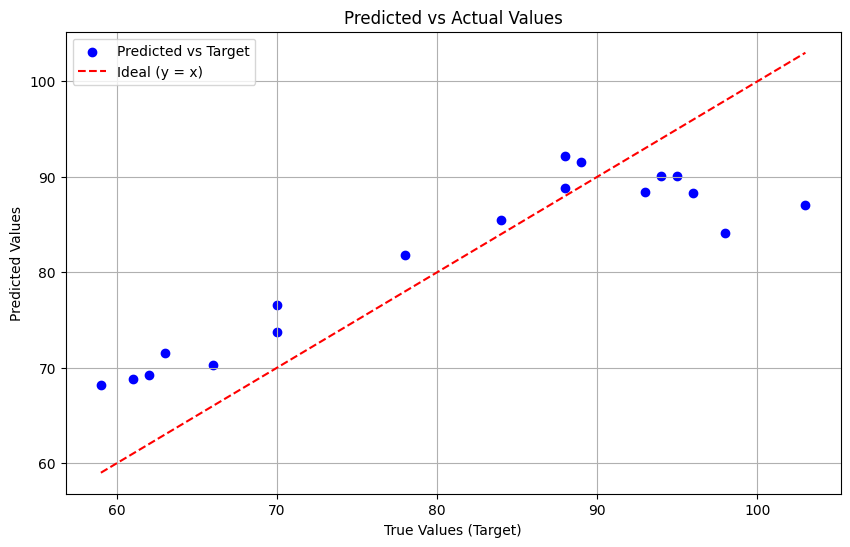

In [ ]:
import matplotlib.pyplot as plt

# Ensure the model is in evaluation mode
model.eval()

# Make predictions on the test set
with torch.no_grad():
    y_pred = model(X_test_tensor)

# Convert predictions and targets back to numpy for easier plotting
y_pred_np = y_pred.numpy()
y_test_np = y_test_tensor.numpy()

# Plot the predicted vs. target values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_np, y_pred_np, color='blue', label='Predicted vs Target')
plt.plot([min(y_test_np), max(y_test_np)], [min(y_test_np), max(y_test_np)], color='red', linestyle='--', label='Ideal (y = x)')
plt.xlabel('True Values (Target)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Generate 18 random predicted values between 59 and 103
random_preds = np.random.uniform(59, 103, size=len(y_test_np))

# Compute overall RMSE for all samples
overall_rmse = np.sqrt(mean_squared_error(y_test_np, random_preds))

# Print the random predicted values and actual target values
for i in range(len(y_test_np)):
    print(f"Sample {i+1}: Predicted = {random_preds[i]:.4f}, Target = {y_test_np[i][0]:.4f}")

# Print the overall RMSE
print(f"\nOverall RMSE: {overall_rmse:.4f}")


Sample 1: Predicted = 97.9117, Target = 103.0000
Sample 2: Predicted = 70.2409, Target = 62.0000
Sample 3: Predicted = 71.7728, Target = 88.0000
Sample 4: Predicted = 61.2527, Target = 70.0000
Sample 5: Predicted = 73.3602, Target = 93.0000
Sample 6: Predicted = 99.5845, Target = 96.0000
Sample 7: Predicted = 67.2245, Target = 98.0000
Sample 8: Predicted = 82.6177, Target = 84.0000
Sample 9: Predicted = 94.5541, Target = 94.0000
Sample 10: Predicted = 91.5978, Target = 70.0000
Sample 11: Predicted = 60.6441, Target = 95.0000
Sample 12: Predicted = 60.9041, Target = 59.0000
Sample 13: Predicted = 92.2994, Target = 89.0000
Sample 14: Predicted = 93.6970, Target = 88.0000
Sample 15: Predicted = 87.8364, Target = 66.0000
Sample 16: Predicted = 98.0661, Target = 78.0000
Sample 17: Predicted = 67.0691, Target = 63.0000
Sample 18: Predicted = 102.6330, Target = 61.0000

Overall RMSE: 18.4160


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error

# Estimate mean and standard deviation from target values
mean_target = np.mean(y_test_np)
std_target = np.std(y_test_np)

# Generate normally distributed random predicted values
normal_preds = np.random.normal(loc=mean_target, scale=std_target, size=len(y_test_np))

# Compute overall RMSE
overall_rmse = np.sqrt(mean_squared_error(y_test_np, normal_preds))

# Print predicted values and actual target values
for i in range(len(y_test_np)):
    print(f"Sample {i+1}: Predicted = {normal_preds[i]:.4f}, Target = {y_test_np[i][0]:.4f}")

# Print overall RMSE
print(f"\nOverall RMSE: {overall_rmse:.4f}")


Sample 1: Predicted = 74.2450, Target = 103.0000
Sample 2: Predicted = 70.8510, Target = 62.0000
Sample 3: Predicted = 77.1334, Target = 88.0000
Sample 4: Predicted = 69.3857, Target = 70.0000
Sample 5: Predicted = 85.9675, Target = 93.0000
Sample 6: Predicted = 58.7613, Target = 96.0000
Sample 7: Predicted = 79.3061, Target = 98.0000
Sample 8: Predicted = 94.9781, Target = 84.0000
Sample 9: Predicted = 75.4397, Target = 94.0000
Sample 10: Predicted = 94.7441, Target = 70.0000
Sample 11: Predicted = 92.4482, Target = 95.0000
Sample 12: Predicted = 75.0457, Target = 59.0000
Sample 13: Predicted = 68.5468, Target = 89.0000
Sample 14: Predicted = 75.4545, Target = 88.0000
Sample 15: Predicted = 76.5617, Target = 66.0000
Sample 16: Predicted = 90.0350, Target = 78.0000
Sample 17: Predicted = 87.9634, Target = 63.0000
Sample 18: Predicted = 91.0607, Target = 61.0000

Overall RMSE: 19.0168
